# E11. Pneumonia

## 1. Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [5]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

root_path = '/content'
train_path = root_path + '/drive/MyDrive/data/e11/train/*/*'
val_path = root_path + '/drive/MyDrive/data/e11/val/*/*'
test_path = root_path + '/drive/MyDrive/data/e11/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(root_path)
print(train_path)

/content
/content/drive/MyDrive/data/e11/train/*/*


## 2. Data load

In [31]:
train_filenames = tf.io.gfile.glob(train_path)
test_filenames = tf.io.gfile.glob(test_path)
val_filenames = tf.io.gfile.glob(val_path)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [32]:
filenames = tf.io.gfile.glob(train_path)
filenames.extend(tf.io.gfile.glob(val_path))

train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [33]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/data/e11/train/PNEUMONIA/person612_bacteria_2477.jpeg
Pneumonia image path
/content/drive/MyDrive/data/e11/train/PNEUMONIA/person264_bacteria_1228.jpeg


In [34]:
count_normal = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set: {count_normal}')

count_pneumonia = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Pneumonia images count in training set: {count_pneumonia}')

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


In [35]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [36]:
train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {train_img_count}')

val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validataing images count: {val_img_count}')

Training images count: 4185
Validataing images count: 1047


In [37]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == "PNEUMONIA"

In [38]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, IMAGE_SIZE)
  return img

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [39]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [41]:
for image, label in train_ds.take(1):
  print("Image Shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image Shape:  (180, 180, 3)
Label:  True


In [42]:
test_list_ds = tf.data.Dataset.list_files(test_path)
test_img_count = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(test_img_count)

624


In [43]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

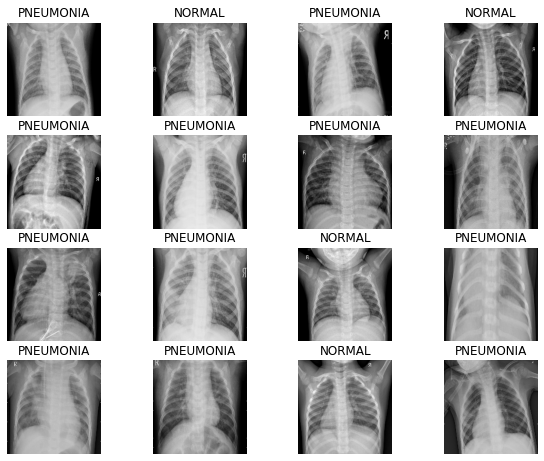

In [44]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
    ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
    plt.imshow(image_batch[n])
    if label_batch[n]:
      plt.title("PNEUMONIA")
    else:
      plt.title("NORMAL")
    plt.axis("off")
  
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [45]:
def conv_block(filters):
  block = tf.keras.Sequential([
                               tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
                               tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.MaxPool2D()
  ])

  return block

In [46]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
                               tf.keras.layers.Dense(units, activation='relu'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Dropout(dropout_rate)
  ])

  return block

In [47]:
def build_model():
  model = tf.keras.Sequential([
                               tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

                               tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
                               tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
                               tf.keras.layers.MaxPool2D(),

                               conv_block(32),
                               conv_block(64),

                               conv_block(128),
                               tf.keras.layers.Dropout(0.2),

                               conv_block(256),
                               tf.keras.layers.Dropout(0.2),

                               tf.keras.layers.Flatten(),
                               dense_block(512, 0.7),
                               dense_block(128, 0.5),
                               dense_block(64, 0.3),

                               tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

In [48]:
def dense_block_2(units, dropout_rate):
  block = tf.keras.Sequential([
                               tf.keras.layers.Dense(units, activation='relu'),
                               tf.keras.layers.Dropout(dropout_rate)
  ])

  return block

In [49]:
def build_model_2():
  model = tf.keras.Sequential([
                               tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

                               tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
                               tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
                               tf.keras.layers.MaxPool2D(),

                               conv_block(32),
                               conv_block(64),

                               conv_block(128),
                               tf.keras.layers.Dropout(0.2),

                               conv_block(256),
                               tf.keras.layers.Dropout(0.2),

                               tf.keras.layers.Flatten(),
                               dense_block_2(512, 0.7),
                               dense_block_2(128, 0.5),
                               dense_block_2(64, 0.3),

                               tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

In [50]:
weight_for_0 = (1 / count_normal)*(train_img_count)/2.0
weight_for_1 = (1 / count_pneumonia)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


In [51]:
with tf.device('/GPU:0'):
  model = build_model()

  METRICS = [
             'accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')
  ]

  model.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics=METRICS
  )

In [52]:
with tf.device('/GPU:0'):
  history=model.fit(
      train_ds,
      steps_per_epoch=train_img_count // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=val_ds,
      validation_steps=val_img_count // BATCH_SIZE,
      class_weight=class_weight
  )

Epoch 1/25
261/261 [==============================] - 113s 371ms/step - loss: 0.4013 - accuracy: 0.8068 - precision: 0.9485 - recall: 0.7813 - val_loss: 0.6022 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 96s 368ms/step - loss: 0.2403 - accuracy: 0.9052 - precision: 0.9694 - recall: 0.9005 - val_loss: 1.4511 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 97s 374ms/step - loss: 0.2218 - accuracy: 0.9138 - precision: 0.9726 - recall: 0.9090 - val_loss: 0.1584 - val_accuracy: 0.9375 - val_precision: 0.9344 - val_recall: 0.9859
Epoch 4/25
261/261 [==============================] - 97s 374ms/step - loss: 0.1892 - accuracy: 0.9253 - precision: 0.9760 - recall: 0.9217 - val_loss: 0.4665 - val_accuracy: 0.8654 - val_precision: 0.9969 - val_recall: 0.8233
Epoch 5/25
261/261 [==============================] - 101s 387ms/step - loss: 0.1736 - accu

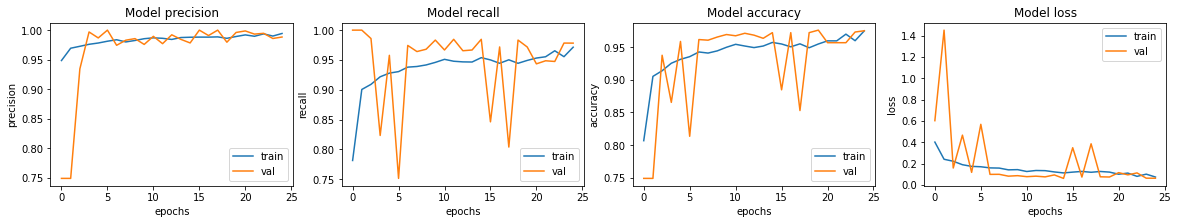

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_'+ met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

In [54]:
with tf.device('/GPU:0'):
  model_2 = build_model_2()

  METRICS = [
             'accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')
  ]

  model_2.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics=METRICS
  )

In [55]:
with tf.device('/GPU:0'):
  history=model_2.fit(
      train_ds,
      steps_per_epoch=train_img_count // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=val_ds,
      validation_steps=val_img_count // BATCH_SIZE,
      class_weight=class_weight
  )

Epoch 1/25
261/261 [==============================] - 114s 375ms/step - loss: 0.3739 - accuracy: 0.8424 - precision: 0.9325 - recall: 0.8486 - val_loss: 0.6417 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 96s 368ms/step - loss: 0.2675 - accuracy: 0.8898 - precision: 0.9762 - recall: 0.8727 - val_loss: 1.3984 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 97s 373ms/step - loss: 0.2309 - accuracy: 0.9085 - precision: 0.9808 - recall: 0.8936 - val_loss: 0.3696 - val_accuracy: 0.8240 - val_precision: 1.0000 - val_recall: 0.7657
Epoch 4/25
261/261 [==============================] - 98s 377ms/step - loss: 0.1957 - accuracy: 0.9212 - precision: 0.9812 - recall: 0.9112 - val_loss: 0.2530 - val_accuracy: 0.9337 - val_precision: 0.9599 - val_recall: 0.9513
Epoch 5/25
261/261 [==============================] - 101s 388ms/step - loss: 0.1753 - accu

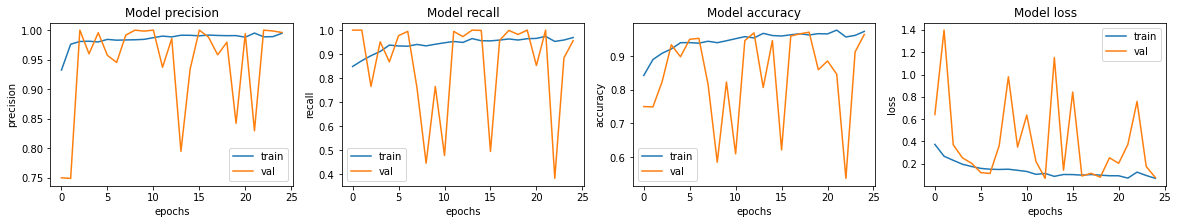

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_'+ met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])